In [3]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import defaultdict
import h5py
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import os
import regex as re
from collections import defaultdict
from scipy.signal import correlate

In [4]:
def get_Ic_time(t, V):
    """
    Find the current where voltage transitions
    from flat (0) to nearly vertical.
    
    Parameters:
    - t: array-like, time values (s)
    - V: array-like, voltage values (mV)
    
    Returns:
    - tIc: float, estimated time at which critical current is reached (s)
    """
    t = np.array(t)
    V = np.array(V)

    # Define a small threshold to account for noise
    threshold = 10

    # Find indices where voltage is below the threshold
    zero_resistance_indices = np.where(V <= threshold)[0]

    if len(zero_resistance_indices) > 0:
        # The last voltage where resistance is (effectively) zero
        critical_index = zero_resistance_indices[-1]
        tIc = t[critical_index]
        print(f"Voltage at critical index is {V[critical_index]}:")
        print(f"Critical current time: {tIc}")
        return tIc, V[critical_index]
    else:
        print("No zero-voltage region found.")
        return None

In [5]:
import numpy as np

def get_Ic_times(t, V, slope_threshold=-1e2):
    """
    Find times where the slope of voltage vs. time sharply drops,
    indicating critical current transitions.

    Parameters:
    - t: array-like, time values (s)
    - V: array-like, voltage values (mV)
    - slope_threshold: float, negative threshold for sharp slope drop

    Returns:
    - tIc: np.ndarray, times at which critical current transitions occur
    - vIc: np.ndarray, voltages at those times
    """
    t = np.array(t)
    V = np.array(V)

    # Compute the slope (dV/dt) using numpy.gradient
    dV_dt = np.gradient(V, t)

    # Find indices where slope sharply drops below the threshold
    critical_indices = np.where(dV_dt < slope_threshold)[0]

    if critical_indices.size > 0:
        tIc = t[critical_indices]
        vIc = V[critical_indices]
        print(f"Critical current times: {tIc}")
        return tIc, vIc
    else:
        print("No zero voltage regions found found.")
        return np.array([]), np.array([])


In [6]:
def calculate_time_delay_and_shift(x, y1, y2):
    """
    Calculate the time delay between two waveforms using FFT-based cross-correlation,
    and return the shifted y2 to align with y1.
    """
    y1 = np.asarray(y1)
    y2 = np.asarray(y2)

    # Normalize
    y1 = (y1 - np.mean(y1)) / np.std(y1)
    y2 = (y2 - np.mean(y2)) / np.std(y2)

    # Use FFT-based correlation for better performance
    correlation = correlate(y1, y2, mode='full', method='fft')

    # Compute lag in number of samples
    lag = np.argmax(correlation) - (len(y2) - 1)

    dt = x[1] - x[0]
    time_delay = lag * dt

    # Pad or crop y2 as needed to align (avoid wrapping with roll)
    if lag > 0:
        # y2 lags behind y1, so shift it forward (prepend zeros)
        y2_shifted = np.pad(y2, (lag, 0), mode='constant')[:len(y2)]
    elif lag < 0:
        # y2 is ahead of y1, shift it backward (cut off front)
        y2_shifted = np.pad(y2, (0, -lag), mode='constant')[-lag:len(y2)-lag]
    else:
        y2_shifted = y2.copy()

    return time_delay, y2_shifted


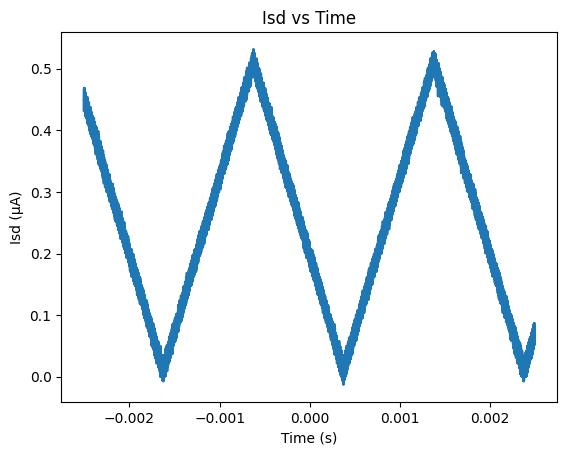

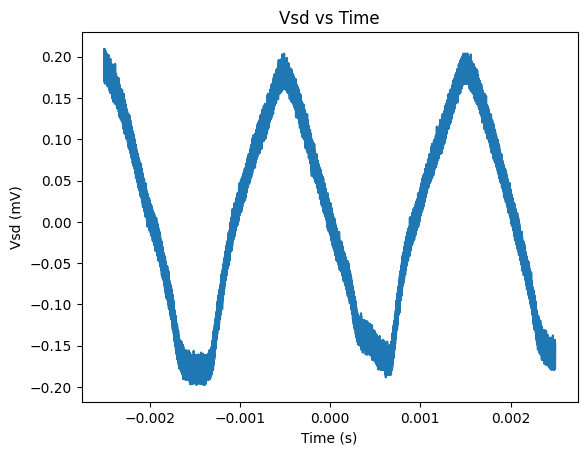

In [ ]:
test_traces_time = pd.read_csv('test_traces0.csv')['Time (s)'].values
test_traces_Isd = pd.read_csv('test_traces0.csv')['Channel 1'].values
test_traces_Vsd = pd.read_csv('test_traces0.csv')['Channel 3'].values

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Isd (µA)')
plt.title('Isd vs Time')
plt.plot(test_traces_time, test_traces_Isd, label='Channel 1')

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Vsd (V)')
plt.title('Vsd vs Time')
plt.plot(test_traces_time, test_traces_Vsd, label='Channel 3')

In [8]:
print(calculate_time_delay_and_shift(test_traces_time, test_traces_Isd, test_traces_Vsd))

(np.float64(-7.836007835807304e-05), array([1.32439387, 1.3695457 , 1.35769893, ..., 0.        , 0.        ,
       0.        ], shape=(1000000,)))


In [5]:
#Getting critical current from Vsd vs t data
get_Ic_time(test_traces_time, test_traces_Vsd)


Voltage at critical index is -0.1630298408:
Critical current time: 0.00249444


np.float64(0.00249444)

In [ ]:
def plot_trace(file_name, title1, title2):
    data = pd.read_csv(file_name)
    time = data['Time (s)'].values
    Isd = data['Channel 1'].values
    Vsd = data['Channel 3'].values

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Isd (µA)')
    plt.title(title1)
    plt.plot(time, Isd, label='Channel 1')

    plt.figure()
    plt.xlabel('Time (s)')
    plt.ylabel('Vsd (V)')
    plt.title(title2)
    plt.plot(time, Vsd, label='Channel 3')

In [ ]:
Ic_voltages = defaultdict(int)

for i in range(1,11):
    data = pd.read_csv(f'JJ11_f=500Hz_trace{i}.csv')
    time = data['Time (s)'].values
    Vsd = data['Channel 3'].values
    Isd = data['Channel 1'].values
    _, Vsd_shifted = calculate_time_delay_and_shift(time, Isd, Vsd)
    _, VIcs = get_Ic_times(time, Vsd_shifted)
    if len(VIcs) > 0:
        for VIc in VIcs:
            rounded_VIc = round(VIc, 2)
            Ic_voltages[rounded_VIc] += 1

FileNotFoundError: [Errno 2] No such file or directory: 'JJ11_f=500Hz_trace1.csv'

[6520, 6258, 6435, 6712, 6146, 6817, 6773, 6212, 6464, 6588, 5968, 6573, 6130, 6283, 6482, 6212, 6667, 5977, 7064, 6221, 6731, 6088, 6184, 6369, 6099, 6152, 6954, 6221, 6389, 6352, 6045, 6649, 6804, 5989, 6279, 6060, 7081, 6097, 5739, 7108, 5851, 5722, 5527, 5901, 5712, 5757, 5673, 5593, 5567, 5612, 5680, 5598, 5769, 5407, 5875, 5530, 5589, 5467, 5670, 6135, 6058, 5518, 6037, 5835, 6078, 5832, 5802, 6089, 5161, 5268, 5449, 5414, 5385, 5532, 5318, 5427, 5586, 5227, 5429, 5447, 5361, 5285, 5361, 5198, 5349, 5470, 5648, 5647, 4654, 5122, 4845, 5165, 5439, 4803, 5441, 4089, 4251, 4380, 4239, 4097, 4126, 4070, 4226, 4190, 4840, 4452, 4907, 4703, 4480, 4802, 4876, 4796, 4907, 4886, 4903, 4679, 4758, 4864, 4649, 4594, 4304, 4799, 3761, 3624, 3576, 3636, 4158, 4090, 3908, 3524, 3918, 3652, 3585, 3506, 3712, 3584, 3612, 3624, 3658, 3366, 3508, 3490, 3562, 3565, 3188, 3460, 3238, 3547, 3326, 2701, 2733, 3058, 3039, 2987, 2973, 2902, 3678, 3760, 3376, 2871, 3578, 2791, 3231, 3312, 3058, 3583, 378

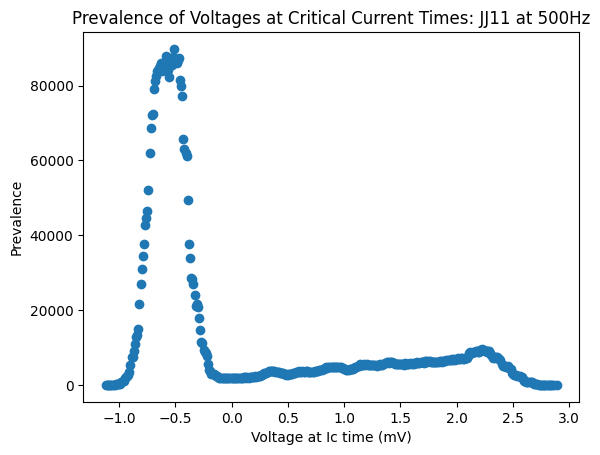

In [15]:
plt.figure()
plt.xlabel('Voltage at Ic time (mV)')
plt.ylabel('Prevalence')
plt.title('Prevalence of Voltages at Critical Current Times: JJ11 at 500Hz')
print(list(Ic_voltages.values()))
plt.scatter(list(Ic_voltages.keys()), list(Ic_voltages.values()))

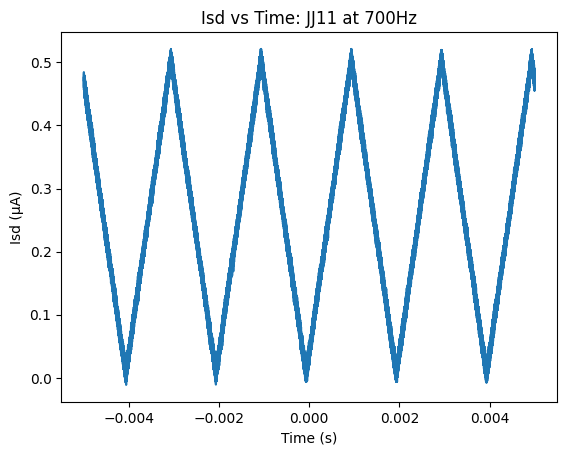

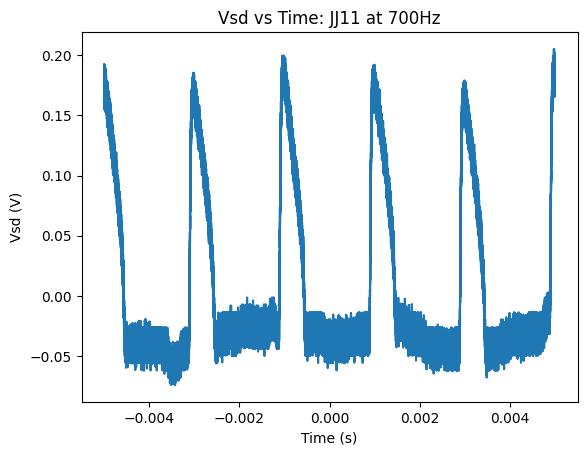

In [13]:
data_700 = pd.read_csv(f'JJ11_f=700Hz_trace1.csv')
time_700 = data['Time (s)'].values
Isd_700 = data['Channel 1'].values
Vsd_700 = data['Channel 3'].values

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Isd (µA)')
plt.title('Isd vs Time: JJ11 at 700Hz')
plt.plot(time_700, Isd_700, label='Channel 1')

plt.figure()
plt.xlabel('Time (s)')
plt.ylabel('Vsd (V)')
plt.title('Vsd vs Time: JJ11 at 700Hz')
plt.plot(time_700, Vsd_700, label='Channel 3')

In [22]:
def plot_Ic_Voltage_distribution(frequency):
    Ic_voltages = defaultdict(int)

    for i in range(1,11):
        data = pd.read_csv(f'JJ11_f={frequency}Hz_trace{i}.csv')
        time = data['Time (s)'].values
        Vsd = data['Channel 3'].values
        Isd = data['Channel 1'].values
        _, Vsd_shifted = calculate_time_delay_and_shift(time, Isd, Vsd)
        _, VIcs = get_Ic_times(time, Vsd_shifted)
        if len(VIcs) > 0:
            for VIc in VIcs:
                rounded_VIc = round(VIc, 2)
                Ic_voltages[rounded_VIc] += 1

    plt.figure()
    plt.xlabel('Voltage at Ic time (mV)')
    plt.ylabel('Prevalence')
    plt.title(f'Prevalence of Voltages at Critical Current Times: JJ11 at {frequency}Hz')
    print(list(Ic_voltages.values()))
    plt.scatter(list(Ic_voltages.keys()), list(Ic_voltages.values()))

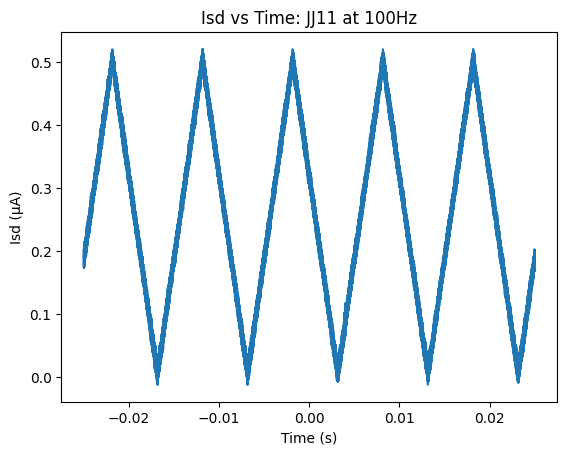

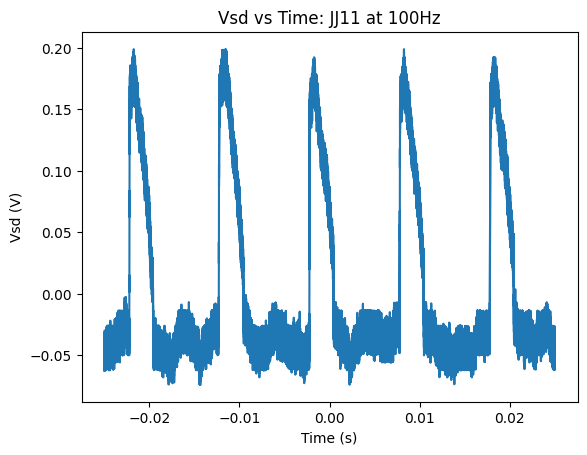

In [20]:
plot_trace('JJ11_f=100Hz_trace1.csv', 'Isd vs Time: JJ11 at 100Hz', 'Vsd vs Time: JJ11 at 100Hz')

Critical current times: [-0.025      -0.02499985 -0.0249998  ...  0.024399    0.02439905
  0.02439915]
Critical current times: [-0.025      -0.02499995 -0.0249998  ...  0.0244006   0.0244007
  0.02440075]
Critical current times: [-0.02499995 -0.0249998  -0.0249996  ...  0.0243683   0.02436835
  0.02436865]
Critical current times: [-0.0249999  -0.02499985 -0.0249998  ...  0.0244223   0.02442255
  0.0244226 ]
Critical current times: [-0.0249999  -0.02499985 -0.0249997  ...  0.0244122   0.02441225
  0.0244126 ]
Critical current times: [-0.025      -0.02499995 -0.02499985 ...  0.02434835  0.02434855
  0.0243486 ]
Critical current times: [-0.025      -0.02499995 -0.0249999  ...  0.0243705   0.02437055
  0.0243707 ]
Critical current times: [-0.025      -0.02499995 -0.02499985 ...  0.024366    0.0243662
  0.02436625]
Critical current times: [-0.025      -0.02499995 -0.0249998  ...  0.0244687   0.02446885
  0.0244689 ]
Critical current times: [-0.025      -0.02499995 -0.0249999  ...  0.0245459

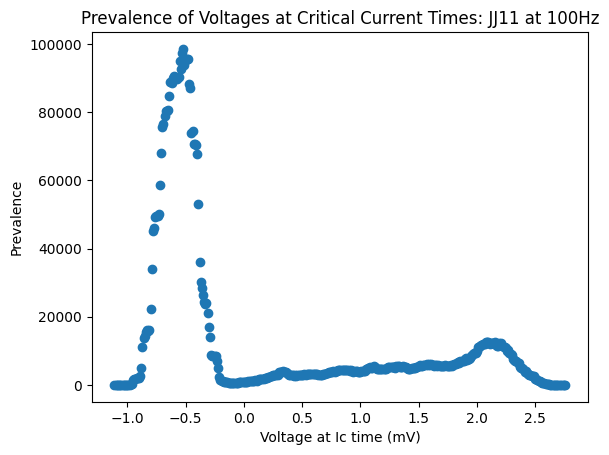

In [23]:
plot_Ic_Voltage_distribution(100)